# Objetivo
A partir de um sinal de vibração genérico: 

    1. Visualizar o sinal no tempo, seus parâmetros estatísticos e histograma. 
    2. Visualizar o sinal na frequênica, identificando os picos dominantes.
    3. Testar os métodos de extração de características.

Abaixo a importação das bibliotecas.

In [273]:
# bibliotecas mais importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
import locale

# tema padrão do seaborn
sns.set_theme()
sns.set_context("notebook", font_scale=1.2)

locale.setlocale(locale.LC_ALL, 'de_DE')
plt.rcParams['axes.formatter.use_locale'] = True

Utilizando o módulo de inicialização, lemos o sinal de um arquivo genérico escolhido.

In [271]:
from initialize import Measurement
address = '../mafaulda/imbalance/35g/33.5872.csv'
ratio = 50

m1 = Measurement(address, ratio, verbose=True)


Sinal com shape (5000, 8)
a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



# Análise no tempo
Temos a visualização deles no tempo.

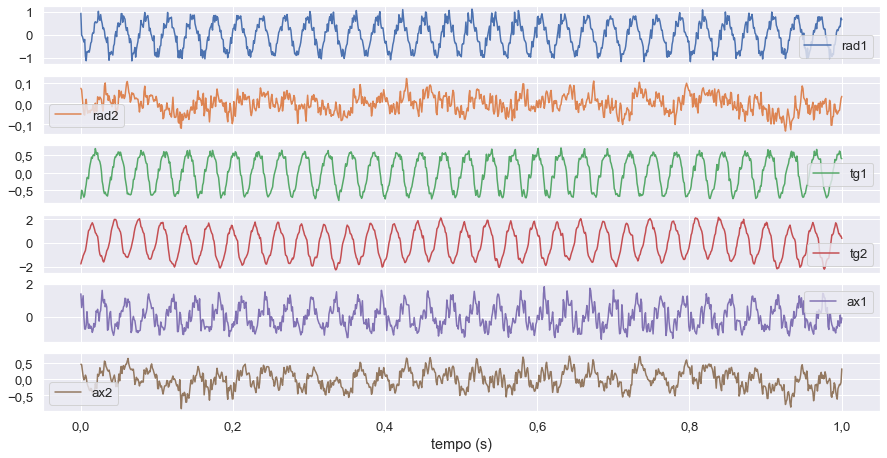

In [274]:
m1.time_acc['tempo (s)'] = np.linspace(0, 5, m1.time.shape[0])
axs = m1.time_acc.loc[:1000].plot(subplots=True, x='tempo (s)', layout=(8,1), figsize=(15,10))
m1.time_acc.pop('tempo (s)')

plt.show()

Note que as amplitudes sao diferentes. Temos uma ideia melhor a partir do boxplot

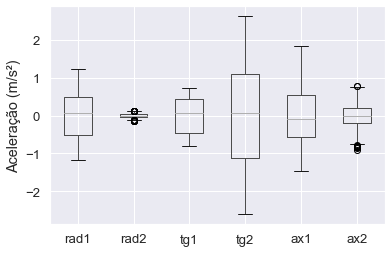

In [4]:
# checa nível dos sinais de aceleração
m1.time_acc.boxplot()
plt.ylabel('Aceleração (m/s²)')
plt.show()

Como curiosidade, pode-se também escutar o som gerado pelo microfone.

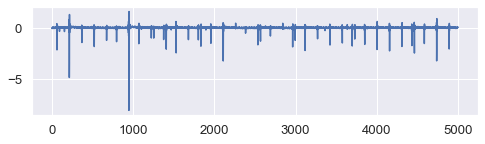

Som do microfone


In [5]:
# detalha sinal do microfone no tempo
m1.time['microfone'].plot(figsize=(8,2))
plt.show()

from IPython.display import Audio, display
print('Som do microfone')
display(Audio(m1.time['microfone'], rate=m1.sampling_freq))

# Extração de parâmetros

Uma referencia para técnicas de extração de características: http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html

## Valores estatísticos

São sugeridos alguns parâmetros. Em destaque, aqueles que já foram implementados:

 - Momentos estatísticos: ~~média~~, desvio padrão, assimetria e curtose
 - Entropia de Shannon, 
 - Suavidade e uniformidade
 - Root-mean-squared (RMS)
 - Valor pico-a-pico da onda
 - Fatores de fomra, de crista, de impulso e de margem
 
Para se ter uma ideia da distribuição dos dados do sinal no tempo, abaixo temos o resumo estatístico e o histograma para cada aceleração medida.

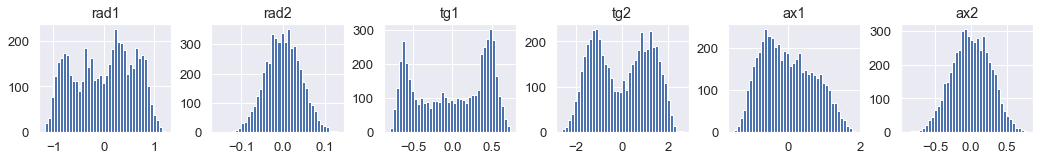

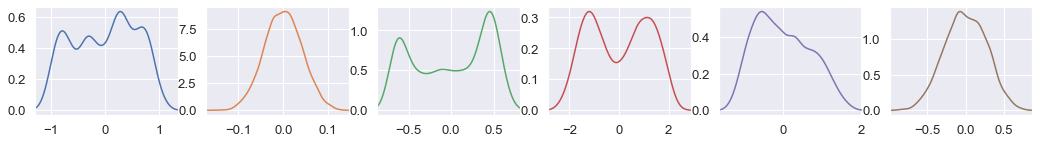

In [252]:
# histograma para cada sinal

axs1 = m1.time_acc.hist(bins=40, figsize=(24,2), layout=(1,8))
axs2 = m1.time_acc.plot.kde(subplots=True, figsize=(24,2), layout=(1,8), 
                            sharex=False, legend=False, ylabel=False)
for ax1, ax2 in zip(axs1[0], axs2[0]):
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylabel('')
    
m1.time_acc.describe(percentiles=[.5])

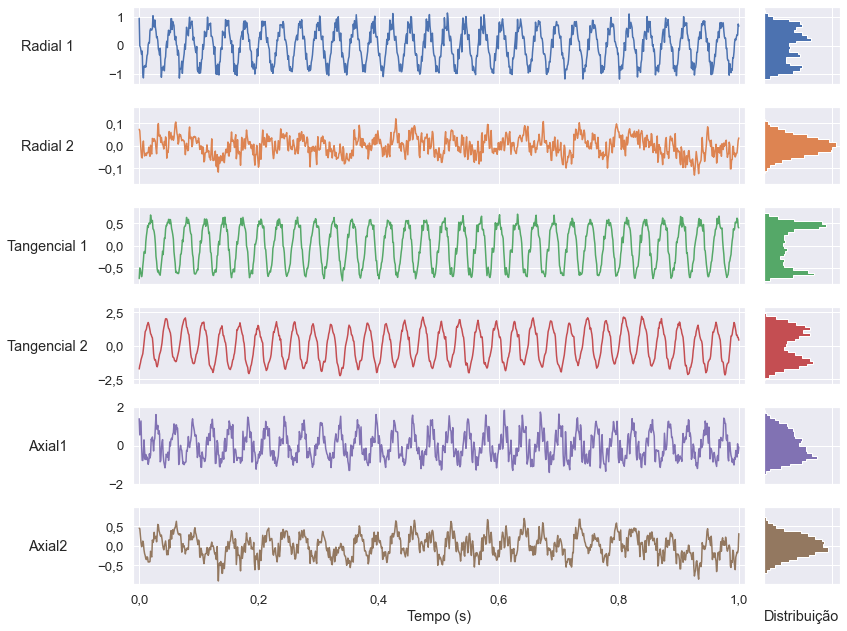

In [275]:
fig, axes = plt.subplots(6, 2, figsize=[12,9], sharex='col', sharey='row',
                         gridspec_kw={'width_ratios': [8, 1]})

m1.time_acc['tempo (s)'] = np.linspace(0, 5, m1.time.shape[0])

acc_slice = m1.time_acc.loc[:1000]
colors = plt.rcParams["axes.prop_cycle"]()

def corrige_nome_eixos(nome):
    return nome.replace('rad', 'Radial ').replace('tg', 'Tangencial ').replace('ax', 'Axial')

for i in range(6):
    c = next(colors)["color"]
    axes[i][0].plot(acc_slice['tempo (s)'], acc_slice.iloc[:, i], color=c)
    m1.time_acc.iloc[:, i].hist(bins=25, ax=axes[i][1], histtype='stepfilled', orientation='horizontal', color=c)
    yabs_max = abs(max(axes[i][0].get_ylim(), key=abs))
    axes[i][0].set_ylim(ymin=-yabs_max, ymax=yabs_max)
    axes[i][0].set_ylabel(corrige_nome_eixos(m1.time_acc.columns[i]), rotation=0, labelpad=50, y=.4)
    axes[i][0].margins(x=0.01)

axes[5][0].set_xlabel("Tempo (s)")
axes[5][1].set_xlabel("Distribuição")
axes[5][1].tick_params(labelbottom=False)
fig.align_ylabels(axes[:, 0])
fig.align_xlabels(axes[5, :])
plt.subplots_adjust(wspace = 0.02)

m1.time_acc.pop('tempo (s)')

plt.tight_layout()
plt.savefig('../redacao/figuras/sinais_tempo', bbox_inches='tight')

Agora, prosseguimos para o cálculo das estatísticas no te

In [280]:
# não utilizada, em avaliação
import statsmodels.api as sm
def calc_differential_entropy(dataframe):
    entropias = pd.Series(dtype='float64')
    
    for col in dataframe.columns.values[:]:
        # divide cada sinal em 100 faixas e faz a contagem para cada faixa
        kde = sm.nonparametric.KDEUnivariate(dataframe[col])
        kde.fit()
        
        entropias[col] = kde.entropy
        
    return entropias


def calc_discrete_entropy(dataframe):
    entropias = pd.Series(dtype='float64')
    
    for col in dataframe.columns.values[:]:
        # divide cada sinal em 100 faixas e faz a contagem para cada faixa
        out = np.histogram(dataframe[col], bins=40)[0]
        # calcula a entropia de shannon
        entropias[col] = stats.entropy(out)
        
    return entropias

time_stats = pd.DataFrame()
time_stats['rms'] = m1.time_acc.pow(2).mean().pow(1/2)
time_stats['sra'] = m1.time_acc.abs().pow(1/2).mean().pow(2)
time_stats['kurtosis'] = m1.time_acc.kurtosis()
time_stats['sqewness'] = m1.time_acc.skew()
time_stats['peak_to_peak'] = m1.time_acc.max() - m1.time_acc.min()

absolute_max = m1.time_acc.abs().max()
absolute_average = m1.time_acc.abs().mean()
time_stats['crest'] = absolute_max / time_stats['rms']
time_stats['impulse'] = absolute_max / absolute_average
time_stats['margin'] = absolute_max / time_stats['sra']
time_stats['shape'] = time_stats['rms'] / absolute_average
time_stats['kurtosis_f'] = time_stats['kurtosis'] / time_stats['rms'].pow(4)
time_stats['entropy'] = calc_discrete_entropy(m1.time_acc)
# time_stats['diff_entropy'] = calc_differential_entropy(m1.time_acc)


time_stats

,rms,sra,kurtosis,sqewness,peak_to_peak,crest,impulse,margin,shape,kurtosis_f,entropy
rad1,0.587906,0.457105,-1.160026,-0.117182,2.396657,2.085294,2.402626,2.682000,1.152176,-9.710391,3.564653
rad2,0.041704,0.028538,-0.143556,-0.011478,0.288962,3.778327,4.698585,5.521421,1.243562,-47459.453188,3.168346
tg1,0.447137,0.368116,-1.448583,-0.210964,1.525483,1.778484,1.977535,2.160263,1.111922,-36.239287,3.541677
tg2,1.223541,1.003990,-1.308421,-0.013443,5.214614,2.138189,2.391365,2.605767,1.118407,-0.583812,3.496910
ax1,0.707859,0.527908,-0.847487,0.295651,3.317147,2.609394,3.080096,3.498872,1.180388,-3.375571,3.493608
ax2,0.269801,0.188927,-0.332417,-0.064614,1.687214,3.334324,4.092130,4.761634,1.227274,-62.735343,3.268029


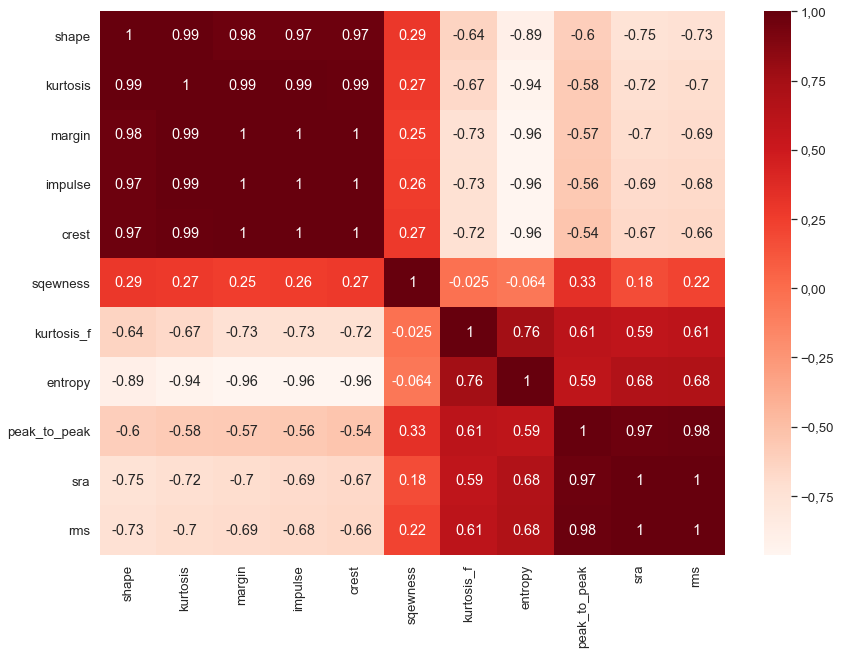

In [282]:
correlation = time_stats.corr()
time_stats = time_stats[correlation.sort_values(by='rms').index]

f, ax = plt.subplots(figsize=(14, 10))
ax =  sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)

In [47]:
freq_stats = pd.DataFrame()

accelerations_fft = m1.freq_acc.iloc[:,:-1]
freq_ax = m1.freq_acc['freq_ax']

sum_axis = accelerations_fft.sum()

freq_stats['freq_center'] = (accelerations_fft.T * freq_ax).T.sum() /  sum_axis
freq_stats['RMSF'] = ((accelerations_fft.T**2 * freq_ax).T.sum() /  sum_axis).pow(1/2)
freq_stats['rvf'] = (((accelerations_fft - freq_stats['freq_center']).T**2 * freq_ax).T.sum() /  sum_axis).pow(1/2)

freq_stats

,freq_center,RMSF,rvf
rad1,166.896671,12.253770,7687.536919
rad2,154.509493,2.786053,17822.835641
tg1,129.334336,10.347796,7644.526203
tg2,93.933734,15.491153,3260.252951
ax1,165.321610,15.201770,6311.473983
ax2,141.604275,6.953219,7427.354975


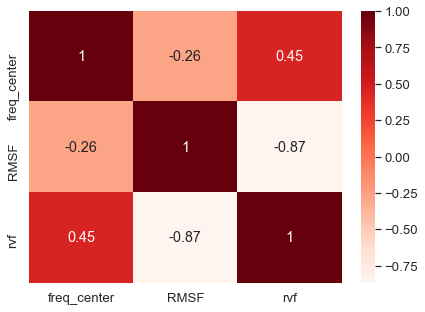

In [55]:
f, ax = plt.subplots(figsize=(7, 5))
ax =  sns.heatmap(freq_stats.corr(), annot=True, cmap=plt.cm.Reds)

## Domínio da frequência
Para a estimar a densidade espectral e demais parâmetros no domínio da frequência, outros métodos são sugeridos. Novamente, aqueles implementados são destacados.
 - ~~Coeficientes de autoregressão~~
 - **Níveis de vibração em frequências características** da máquina
 - Centro da frequência
 - RMS da frequência
 - Variancia e root-variance da frequência
 - Spectral skewness, kurtosis, entropy
 - Características similares no espectro em altas ordens

## Fundamental
A primeira frequência de interesse é a de rotação do eixo. Ela é obtida a partir do espectro do tacômetro.

In [254]:
def extract_rotacao_calc(fft_df):
    tachometer_fft = fft_df['tacometro'].copy(deep=True)
    candidates = [0, 0, 0]
    
    # separa os 3 maiores picos na fft do tacômetro
    for i in range(3):
        index = tachometer_fft.argmax()
        candidates[i] = fft_df.freq_ax[index]
        
        # retira da próxima iteração os valores adjacentes ao pico separado
        for j in range(-2, 3):
            tachometer_fft[index+j] = 0
    
    # deve retornar pico o de menor frequência, evitando o mascaramento da rotacao_calc pelas harmonicas
    rotacao_calc = min(candidates)
    index = fft_df.index[fft_df['freq_ax'] == rotacao_calc]
    
    return rotacao_calc, index[0]


rotacao_calc, index = extract_rotacao_calc(m1.freq)
print("Fundamental de {:0.2f} Hz, no índice {}".format(rotacao_calc, index))

Fundamental de 32.80 Hz, no índice 164


Pode-se comprovar a correta aquisição da rotacao_calc pelo plot abaixo.

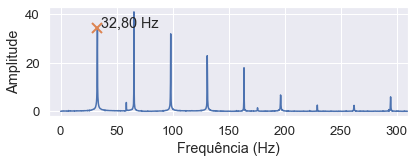

In [277]:
fig, ax = plt.subplots(figsize=[6,2.5], tight_layout=True)
ax.plot(m1.freq['freq_ax'], m1.freq['tacometro'])
ax.plot(rotacao_calc, m1.freq.loc[index, 'tacometro'], "x", markersize=10, mew=2)
ax.annotate('{:.2f} Hz'.format(rotacao_calc).replace('.',','), xy=(rotacao_calc+3, m1.freq.loc[index, 'tacometro']))
ax.set_xlim(-10,310)

ax.set_xlabel("Frequência (Hz)")
ax.set_ylabel("Amplitude")

plt.savefig('../redacao/figuras/tacometro_freq', bbox_inches='tight')
plt.show()

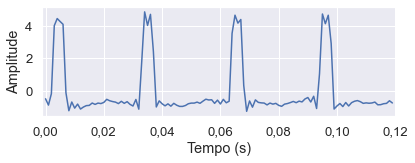

In [278]:
fig, ax = plt.subplots(figsize=[6,2.5], tight_layout=True)
tempo = np.linspace(0, 5, m1.time.shape[0])

ax.plot(tempo[0:120], m1.time['tacometro'][0:120])
ax.margins(x=0.01)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Amplitude")
plt.savefig('../redacao/figuras/tacometro_tempo', bbox_inches='tight')
plt.show()

## Hamônicas
A extração das hamônicas é feita encontrando o máximo em faixas ao redor da posição esperada para o pico. 

In [10]:
# função implementada na extração de dados

def extract_n_harmonics(fft_df, idx, n_harmonics=3):
    # extrai todos os valores nos n primeiros harmônicos, exceto de freq_ax
    fft_df = fft_df.drop('freq_ax', axis=1)

    harmonic_features = pd.DataFrame(dtype='float64')
    
    for i in range(1, n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        harm_values = fft_df.iloc[idx*i-25:idx*i+26].max()
        
        # cria o dataframe com as harmônicas
        harmonic_features["{}th harmonic".format(i)] = harm_values
    
    harmonic_features.loc['freq_ax'] = rotacao_calc * np.arange(1,n_harmonics+1)
    
    
    return harmonic_features

harmonics = extract_n_harmonics(m1.freq_acc, index, 5)

harmonics

,1th harmonic,2th harmonic,3th harmonic,4th harmonic,5th harmonic
rad1,110.513650,2.736137,1.178750,3.304584,3.978080
rad2,1.839627,0.413822,0.369291,0.437201,0.208003
tg1,26.723703,2.154328,1.675678,1.027513,2.779694
tg2,88.343812,11.801322,6.929698,6.625357,8.017141
ax1,50.305820,3.827180,6.084139,34.564660,10.866485
ax2,7.946846,1.780039,0.923630,2.720178,2.003317
freq_ax,55.400000,110.800000,166.200000,221.600000,277.000000


Uma amostra dos picos selecionados pelo algoritmo:

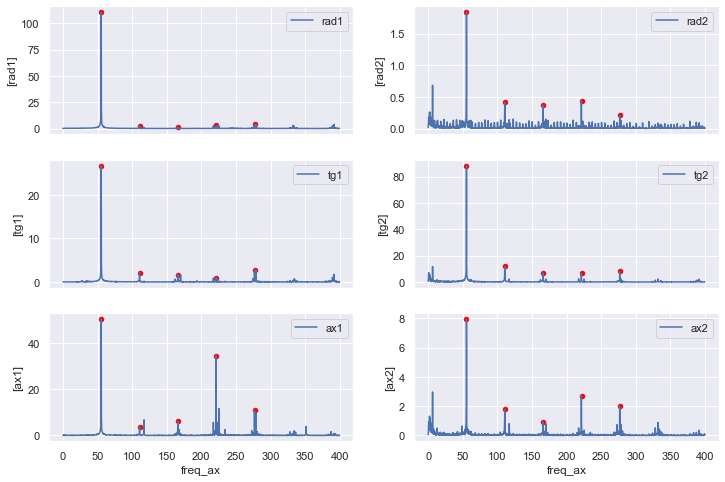

In [11]:
# gera os plots
fig, axes = plt.subplots(3,2,figsize=(12, 8),sharex=True)
for i, col in enumerate(m1.freq_acc.columns.values[:-1]):
    m1.freq[:2000].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonics.T.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

# Experimentos

## Alternativas ao FFT na análise do espectro

Além do FFT puro, pode-se fazer uma estimativa mais geral dos componentes de frequência por outros métodos de análise. Testamos o periodigrama e o periodigrama de Welch.

In [12]:
def generate_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.periodogram(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

def generate_welch_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.welch(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

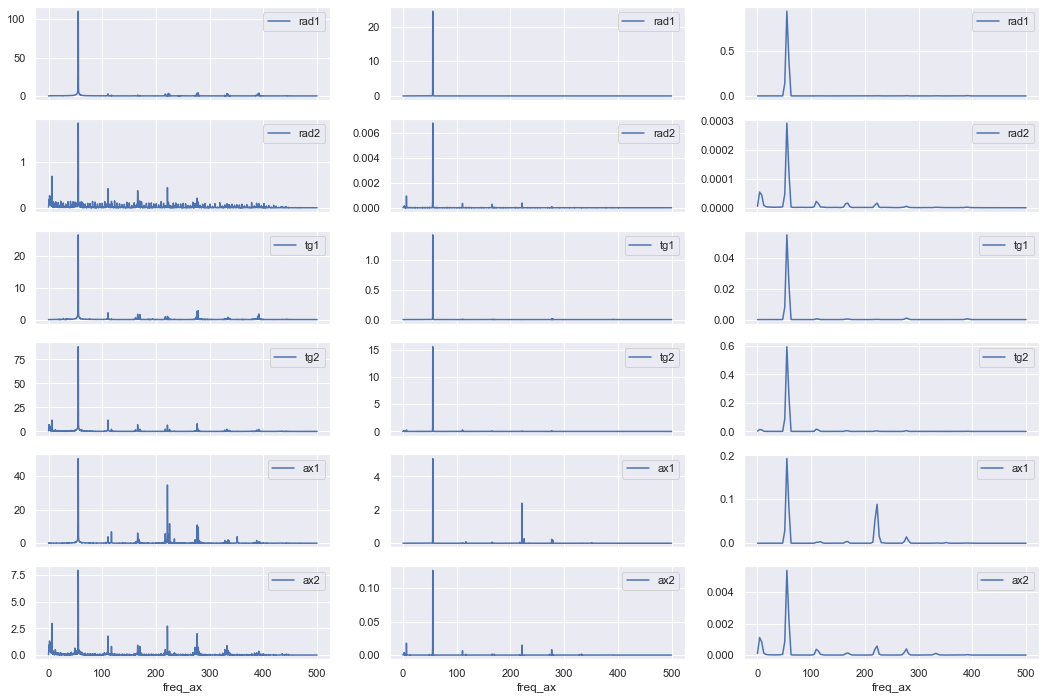

In [13]:
periodgrams = generate_periodgram(m1.time_acc, m1.sampling_freq)
welch = generate_welch_periodgram(m1.time_acc, m1.sampling_freq)

fig, axes = plt.subplots(6,3,figsize=(18, 12),sharex=True)

for i, col in enumerate(m1.freq_acc.columns.values[:-1]):
    m1.freq_acc.plot(x='freq_ax', y=[col], ax=axes[i, 0])
    periodgrams.plot(x='freq_ax', y=[col], ax=axes[i, 1])
    welch.plot(x='freq_ax', y=[col], ax=axes[i, 2])

Nota-se que o valor dos picos é diminuído am termos absolutos, mas se destacam mais em relação ao carpete.

## Análise das velocidades

O sinal de aceleração pode ser integrado para obtenção da velocidade no mesmo eixo. Esta interação, no entanto, acaba exacerbando componentes de baixa frequência. Para evitar a dominação se componentes espúrios de baixa frequência, propõe-se a aplicação de um filtro passa alta depois (ou antes) da integração.

*Nota*: alguns dos sinais de aceleração possuem componentes de 'corrente contínua' (CC), de frequência igual a zero. Elas idicariam que o aquipamento do ensaio possui uma aceleração líquida não nula em algumas das direções. No entanto, o ensaio foi feito sobre báse estática e portanto esse tipo de aceleração não é válida e deve ser ignorada/removida.

Abaixo o filtro butterworth utilizado:

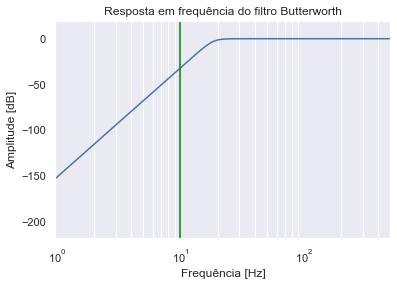

In [14]:
# ilustração do filtro passa alta
from scipy import signal

# define um filtro passa alta arbitrário em 1/3 da rotacao_calc 
b, a = signal.butter(6, rotacao_calc/3, 'highpass', fs=m1.sampling_freq)
w, h = signal.freqz(b, a, fs=m1.sampling_freq)
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Resposta em frequência do filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(10, color='green') # cutoff frequency
plt.show()

Abaixo integramos os sinais com e sem aplicar o filtro.

In [15]:
from scipy import integrate

# transforna-se o sinal de g para m/s²
m1.time_acc_mmps2 = m1.time_acc*9.80665*1000

# instancia o filtro passa alta
sos = signal.butter(6, 10, 'highpass', fs=m1.sampling_freq, output='sos')

# calcula velocidade pela integral (trapezoidal) dos sinais
velocity_no_filter     = pd.DataFrame()
velocity_filter_before = pd.DataFrame()
filtered_acc           = pd.DataFrame()
velocity_filter_after  = pd.DataFrame()


dt = 1/m1.sampling_freq
for col in m1.time_acc_mmps2.columns:
    velocity_no_filter[col] = integrate.cumtrapz(y=np.array(m1.time_acc_mmps2[col]), dx=dt, initial=0)
    correcao = velocity_no_filter[col].mean()
    velocity_no_filter[col] = velocity_no_filter[col].apply(lambda x: x - correcao)
    
    filtered_acc[col] = signal.sosfilt(sos, m1.time_acc_mmps2[col])
    velocity_filter_before[col] =  integrate.cumtrapz(y=np.array(filtered_acc[col]), dx=dt, initial=0)

    velocity_filter_after[col] = integrate.cumtrapz(y=np.array(m1.time_acc_mmps2[col]), dx=dt, initial=0)
    velocity_filter_after[col] = signal.sosfilt(sos, velocity_filter_after[col])


Nota-se que o sinal não filtrado teve os componentes de baixa frequencia amplificados pela integração.

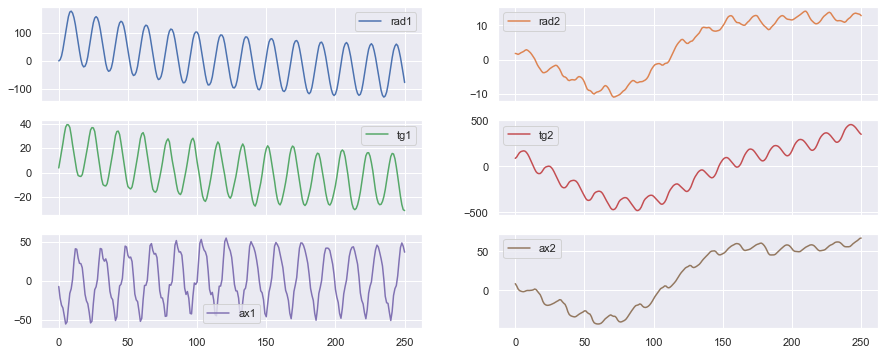

In [16]:
# velocidade NÃO FILTRADA no tempo 
velocity_no_filter.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

Há diferença entre filtrar os sinais antes ou depois da integração. Filtrar antes garante a remoção dos componentes de CC.

In [17]:
pd.DataFrame({
    'média filtro antes': velocity_filter_after.mean(),
    'média filtro depois': velocity_filter_before.mean()
})

,média filtro antes,média filtro depois
rad1,0.055108,0.149510
rad2,0.002072,-0.076932
tg1,0.005690,-3.405247
tg2,0.037639,-2.359346
ax1,0.007777,6.394279
ax2,0.001951,0.574486


Abaixo, os mesmos sinais na velocidade quando há filtragem antes da interação.

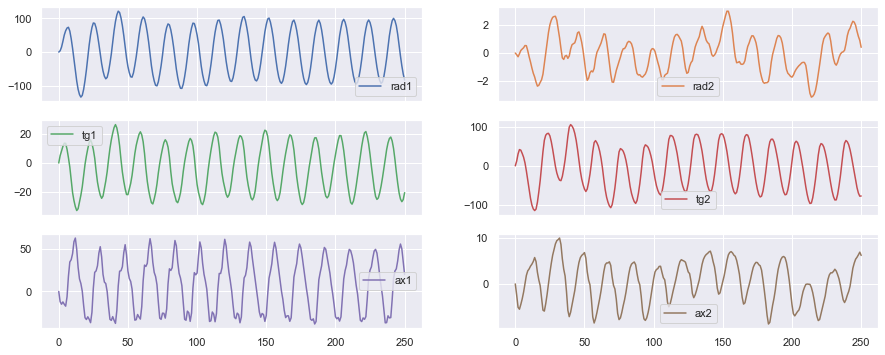

In [18]:
# velocidades FILTRADAS no tempo 
velocity_filter_before.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

In [19]:
# aplica a transformada no sinal filtrado                                     
velocity_fft = velocity_filter_before.apply(np.fft.rfft, axis=0, norm="ortho")
velocity_fft = velocity_fft.apply(np.abs)
velocity_fft['freq_ax'] = np.linspace(0, m1.sampling_freq/2+1, m1.freq.shape[0])

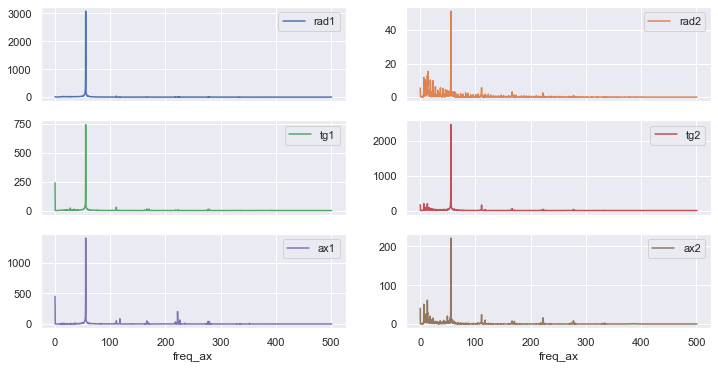

In [20]:
# velocidades na frequência
velocity_fft.loc[:5000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(12,8))
plt.show()

In [21]:
# faz tabulação dos valores de velocidade
vel = velocity_fft.iloc[index]
vel.name = 'velocidade'
vel = vel/vel.max()

acc = m1.freq_acc.iloc[index]
acc.name = 'aceleração'
acc = acc/acc.max()

pd.DataFrame([vel,acc])

,rad1,rad2,tg1,tg2,ax1,ax2,freq_ax
velocidade,1.0,0.016653,0.241838,0.799563,0.455577,0.071866,0.018010
aceleração,1.0,0.016646,0.241814,0.799393,0.455200,0.071908,0.501296


Nota-se que os valores de pico na velocidade e na aceleração apresentam a mesma relação de grandeza entre si.

No entanto, analisando os valores RSM há pequenas variações, possivelmente devido ao filtro passa alta.

RMS velocidades: [66.87454686180519, 1.512539642731915, 16.1730564599187, 54.319656637351585, 30.727609769309698, 6.010590116659699]
RMS acelerações: [2.406434334479789, 0.05640340234687248, 0.5945867569539005, 2.0052394336294674, 1.4089088846510927, 0.24109836616523111]
Valores de RMS:


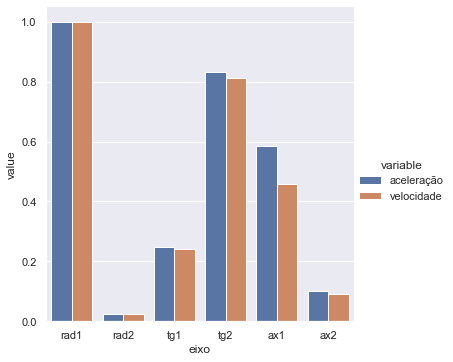

In [22]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

rms_vel = []
for col in velocity_filter_after.columns:
    rms_vel.append( rms(np.array(velocity_filter_after[col])) )
print('RMS velocidades:', rms_vel)

rms_acc = []
for col in m1.time_acc.columns:
    rms_acc.append( rms(np.array(m1.time_acc[col])) )
print('RMS acelerações:', rms_acc)

RMS_values = pd.DataFrame({
    'eixo':  m1.time_acc.columns,
    'aceleração': rms_acc/np.array(rms_acc).max(),
    'velocidade': rms_vel/np.array(rms_vel).max(),
})

print('Valores de RMS:')
sns.catplot(data = RMS_values.melt(id_vars='eixo'), kind='bar', x='eixo', y='value', hue='variable');

## Extração ingênua dos picos na frequência
Note que há uma série de valores elevados em torno de um mesmo pico, confundindo a análise.

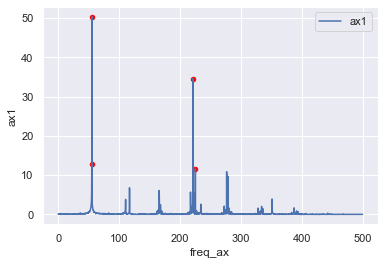

,freq_ax,ax1,n_harmonic
277,55.400,50.306,1.000
1107,221.400,34.565,3.996
276,55.200,12.873,0.996
1127,225.400,11.614,4.069


In [23]:
STUDY_FFT = m1.freq[['freq_ax','ax1']]

col_name = STUDY_FFT.columns[1]
ordered_study_fft = STUDY_FFT.sort_values(by=col_name, ascending=False) # ordenando o sinal
ordered_study_fft['n_harmonic'] = ordered_study_fft['freq_ax']/rotacao_calc

pd.options.display.float_format = '{:,.3f}'.format


ax = m1.freq.iloc[:10000,:].plot(x='freq_ax', y=col_name)
ordered_study_fft.iloc[:4,:].plot(x='freq_ax', y=col_name, kind='scatter', color='red', ax=ax)
plt.show()

# mostra tabela
ordered_study_fft.iloc[:4,:]